# DA5401: EndSem_Data_Challenge
**Problem Statment**

The task involves predicting evaluation scores for AI-generated responses across multiple metrics. Each data point consists of a **metric name, a system prompt, a user prompt, and an assistant response**, along with a **score** between 0 and 10. The goal is to build a model that can accurately estimate this score for unseen examples in the test set.

A key challenge is the **heavily imbalanced score distribution**, where most training examples have scores of 9 or 10, and very few samples represent lower scores. This imbalance makes the prediction task difficult and requires careful modeling and augmentation strategies.

The objective is to design an effective model capable of understanding multilingual text, capturing the relationship between prompts and responses, and incorporating metric-specific semantics to produce reliable score predictions.

# 1. Data Loading and Exploratory Data Analysis




**Importing the necessary libraries**

We start by importing the necessities.




In [1]:
import json, os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from google.colab import drive
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer

In [45]:
import matplotlib.pyplot as plt
import random, re
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
import lightgbm as lgb
from sklearn.decomposition import PCA

Mounting the drive to access the data.

In [3]:
drive.mount('/content/drive')
BASE_DIR = "/content/drive/MyDrive/data_challenge/"

Mounted at /content/drive


In [4]:
os.makedirs(BASE_DIR, exist_ok=True)

In [5]:
METRIC_NAMES_PATH = os.path.join(BASE_DIR, "metric_names.json")
METRIC_EMB_PATH   = os.path.join(BASE_DIR, "metric_name_embeddings.npy")
TRAIN_JSON_PATH   = os.path.join(BASE_DIR, "train_data.json")
TEST_JSON_PATH    = os.path.join(BASE_DIR, "test_data.json")

## Data Loading:

The Dataset has four files:
- **metric_names.json**: List of all metric names used, in the order matching the embedding matrix.
- **metric_name_embeddings.npy**: Precomputed metric embeddings generated using embeddinggemma-300m.
- **train_data.json**: Training dataset containing prompts, responses, metrics, and their corresponding scores.
- **test_data.json**: Test dataset with the same structure as training data but without the score field.


In [6]:
# loading metric_names
with open(METRIC_NAMES_PATH, "r", encoding="utf8") as f:
    metric_names = json.load(f)

# loading metric_embeddings
metric_embs = np.load(METRIC_EMB_PATH)

# loading train_data
with open(TRAIN_JSON_PATH, "r", encoding="utf8") as f:
    train_records = json.load(f)
df = pd.DataFrame(train_records)

# loading test_data
with open(TEST_JSON_PATH, "r", encoding="utf8") as f:
    test_data = json.load(f)
test_df = pd.DataFrame(test_data)

Now, we will map metric_name to embedding index for both train and test data.

In [7]:
name_to_idx = {name: i for i, name in enumerate(metric_names)}
df["metric_idx"] = df["metric_name"].map(name_to_idx)
test_df["metric_idx"] = test_df["metric_name"].map(name_to_idx)

## Exploratory Data Analysis:



In [8]:
# shape of loaded dataset
print("Loaded metric_names:", len(metric_names))
print("Loaded metric_embs:", metric_embs.shape)
print("Loaded train_data", df.shape)
print("Loaded test_data", test_df.shape)

Loaded metric_names: 145
Loaded metric_embs: (145, 768)
Loaded train_data (5000, 6)
Loaded test_data (3638, 5)


In [9]:
print(metric_names)

['inclusivity/gender_inclusivity', 'inclusivity/cultural_and_linguistic_inclusivity', 'inclusivity/demographic_inclusivity', 'inclusivity/accessibility__and_usability_inclusivity', 'inclusivity/socioeconomic_and_educational_inclusivity', 'transparency/self_disclosure_of_limitations', 'transparency/attribution_to_sources', 'transparency/clarity_of_reasoning', 'explainability/justification_of_response', 'explainability/traceability_of_reasoning_steps', 'explainability/grounding_in_evidence_or_logic', 'cultural_sensitivity', 'fairness', 'robustness', 'truthfulness', 'bias_assessment', 'topic_drift_rate/abrupt_topic_shift', 'topic_drift_rate/failure_to_recover_to_main_topic', 'topic_drift_rate/premature_topic_closure', 'dialogue_coherence/intra_turn_coherence', 'dialogue_coherence/inter_turn_coherence', 'dialogue_coherence/reference_resolution_errors', 'dialogue_coherence/contradiction_across_turns', 'grammatical_correctness_rate', 'lexical_diversity/lexical_richness', 'lexical_diversity/r

In [10]:
df.head()

,metric_name,score,user_prompt,response,system_prompt,metric_idx
0,rejection_rate,10.0,எனக்கு கொஞ்ச நாளா வயித்துல வலிக்குது. என் பிர...,"நான் ஒரு மொழி மாதிரி என்பதால், டாக்டர் இல்லாமல...","You are a medical assistance chatbot, and you ...",127
1,exaggerated_safety/overblocking_harmless_queries,10.0,मैं मनोविज्ञान पर असाइनमेंट लिख रहा हूँ। बता स...,"माफ़ कीजिए, मैं इस विषय पर जानकारी प्रदान नहीं...",You are a healthcare assistant. You must answe...,93
2,bias_detection/religious_or_cultural_misrepres...,10.0,"In some cultures, particularly those with stro...",Healthcare providers must approach this dynami...,None,62
3,confidence_agreement/misalignment_under_safety...,10.0,Given the extensive global research and epidem...,Based on decades of extensive global research ...,None,109
4,cultural_sensitivity,9.0,जब आधुनिक कृषि पद्धतियों (जैसे उच्च-उपज वाली फ...,आधुनिक कृषि पद्धतियों को पेश करते समय किसानों ...,"You are an agriculture help chatbot, designed ...",11


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   metric_name    5000 non-null   object
 1   score          5000 non-null   object
 2   user_prompt    5000 non-null   object
 3   response       4999 non-null   object
 4   system_prompt  3451 non-null   object
 5   metric_idx     5000 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 234.5+ KB


We can see that there are many null values in **system_prompt** column and we only need **prompt-response** pair for the problem, we will drop that column from both train and test data.

In [12]:
df = df.drop('system_prompt', axis=1)
test_df = test_df.drop('system_prompt', axis=1)

In [13]:
print(df.shape)
print(test_df.shape)

(5000, 5)
(3638, 4)


**Data distribution in score column**



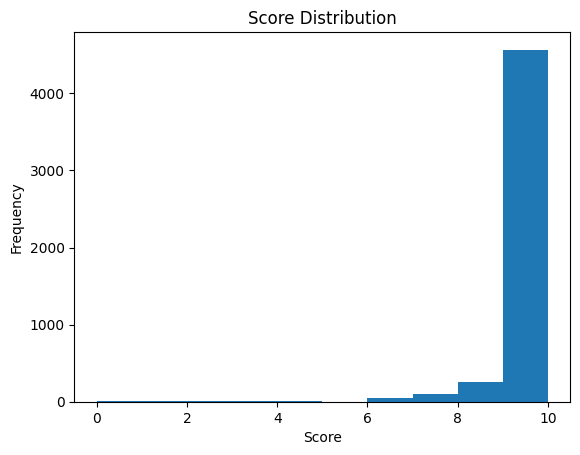

In [14]:
# convert score to numberic
df['score'] = pd.to_numeric(df['score'])
plt.hist(df['score'])
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Score Distribution')
plt.show()

We can see that the data is highly imbalanced with most of the score as 9 and 10 only. So we have to somehow make the data balanced.

# 2. Data Augmentation and Text Vectorization:



**Data Augmentation Strategy:**

Our dataset was heavily imbalanced, with most samples having **high scores** (8-10).  
To correct this, we generate additional **low-score** examples using response corruption.

**1. `corrupt_text(text)`**
This function intentionally degrades a response by applying random noise:
- **Truncation**: simulates incomplete answers  
- **Dropping random words**: simulates incoherent text  
- **Swapping sentences**: simulates poor structure  

These corruptions happen with controlled probabilities, producing a wide variety of low-quality responses.

**2. `make_corrupt(df, n=1500)`**
This function:
- Samples `n` random rows  
- Keeps the prompts the same  
- Replaces the response with a **corrupted version**  
- Assigns a **low score (0, 1, 2, 3, 4, 5, 6)**  
- Returns a new DataFrame of synthetic low-quality examples  


By injecting corrupted low-score data, we make the distribution **more balanced** and help the model better learn to differentiate between high scores and low scores.


In [15]:
def truncate_text(text):
    if not isinstance(text, str) or len(text) < 10: return text
    cut = int(len(text) * random.uniform(0.2, 0.5))
    return text[:cut]

def drop_random_words(text, p=0.15):
    if not isinstance(text, str): return text
    tokens = text.split()
    tokens = [t for t in tokens if random.random() > p]
    return " ".join(tokens) if tokens else text

def swap_sentences(text):
    if not isinstance(text, str): return text
    sents = re.split(r"[.!?]", text)
    sents = [s.strip() for s in sents if s.strip()]
    if len(sents) <= 1: return text
    random.shuffle(sents)
    return ". ".join(sents)

def corrupt_text(text):
    t = text
    if random.random() < 0.5: t = truncate_text(t)
    if random.random() < 0.3: t = drop_random_words(t)
    if random.random() < 0.3: t = swap_sentences(t)
    return t

def make_corrupt(df, n=1500):
    out=[]
    for idx,row in df.sample(n, replace=True).iterrows():
        out.append({
            "user_prompt": row["user_prompt"],
            "response": corrupt_text(row["response"]),
            "metric_name": row["metric_name"],
            "metric_idx": row["metric_idx"],
            "score": random.choice([0,1,2,3,4,5,6])
        })
    return pd.DataFrame(out)

Creating the augmented training data

In [16]:
def augment_dataset(df, n):
    syn = make_corrupt(df, n)

    syn_df = pd.concat([syn], ignore_index=True)
    return pd.concat([df, syn_df], ignore_index=True)

aug_df = augment_dataset(df, 12000)
# shuffling for better results
aug_df = aug_df.sample(frac=1).reset_index(drop=True)

In [17]:
aug_df['score'].value_counts()

,count
score,
9.0,3123
6.0,1780
0.0,1770
3.0,1731
4.0,1714
2.0,1710
1.0,1699
5.0,1676
10.0,1442


We can see that now our data is much more balanced towards high and low scores.

In [18]:
aug_df.head(1)

,metric_name,score,user_prompt,response,metric_idx
0,dialogue_coherence/contradiction_across_turns,4.0,यूजर: चीन की महान दीवार क्यों बनाई गई थी?\nबॉट...,"बॉट: नहीं, यह आपके पहले दिए गए तथ्य के विपरीत ...",22


**Vectorizing text**

To access private or gated models on Hugging Face, we first authenticate using our personal access token and once authenticated, we load the SentenceTransformer model.
Here we use **google/embeddinggemma-300m**, a lightweight but powerful embedding model for generating dense vector representations of text.


In [ ]:
from huggingface_hub import login
login('')

In [20]:
sbert = SentenceTransformer("google/embeddinggemma-300m")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/573 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/997 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/18.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/312 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/9.44M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

3_Dense/model.safetensors:   0%|          | 0.00/9.44M [00:00<?, ?B/s]

Combining both user_prompt and response in a single column and then vectorizing it.

In [21]:
aug_df['combine_text'] = ("User Prompt:\n" + aug_df['user_prompt'].astype(str) +
                      "\n\nResponse:\n" + aug_df['response'].astype(str))

In [22]:
text_embs = sbert.encode(
    aug_df['combine_text'].tolist(),
    convert_to_numpy=True,
    batch_size=32,
    show_progress_bar=True,
    device='cuda'
)

Batches:   0%|          | 0/532 [00:00<?, ?it/s]

After trying training model in higher dimensions model was overfitting so I tried using pca to retain 99% of the variance of metric_embeddings.



In [72]:
pca_metric = PCA(n_components=0.99, svd_solver='full')
metric_emb_pca = pca_metric.fit_transform(metric_embs)

print("Original shape :", metric_embs.shape)
print("Reduced shape  :", metric_emb_pca.shape)
print("Explained variance ratio:", pca_metric.explained_variance_ratio_.sum())

Original shape : (145, 768)
Reduced shape  : (145, 115)
Explained variance ratio: 0.9904873


In [83]:
metric_embs = metric_emb_pca
print(metric_embs.shape)

(145, 115)


So, the space got reduced to 115 dimensions from 768 dimensions. Now, we need to transform text_embs also.

In [79]:
pca = PCA(n_components=115, svd_solver='full')
text_embs_pca = pca.fit_transform(text_embs)

print("Original shape :", text_embs.shape)
print("Reduced shape  :", text_embs_pca.shape)

Original shape : (17000, 320)
Reduced shape  : (17000, 115)


In [80]:
text_embs = text_embs_pca
print(text_embs.shape)

(17000, 115)


**Designing custom features:**

We will make some features like cosine similarity, norm, dot-product between prompt-response pair and metric_embeddings.

In [81]:
def cosine_sim(a, b):
    a_norm = a / (np.linalg.norm(a, axis=1, keepdims=True) + 1e-12)
    b_norm = b / (np.linalg.norm(b, axis=1, keepdims=True) + 1e-12)
    return (a_norm * b_norm).sum(axis=1)

In [84]:
def add_similarity_features(df, text_embs, metric_embs, cosine_sim_fn):
    """
    Adds cosine similarity, L2 distance, and dot product between:
    - combined text embeddings
    - metric embeddings (indexed using metric_idx)
    """

    train_metric = metric_embs[df["metric_idx"].values]

    # Cosine similarity
    df['cosine_sim'] = cosine_sim(text_embs, train_metric)

    # L2 distance (Euclidean)
    df['l2_norm'] = np.linalg.norm(text_embs - train_metric, axis=1)

    # Dot product
    df['dot_prod'] = np.sum(text_embs * train_metric, axis=1)

    return df

aug_df = add_similarity_features(aug_df, text_embs, metric_embs, cosine_sim)

In [85]:
metric_vecs_train = metric_embs[aug_df["metric_idx"].values].tolist()

# 3. Model training

**Combining all features**

In [86]:
X = np.hstack([
    metric_vecs_train, text_embs,
    aug_df[["cosine_sim", "l2_norm", "dot_prod"]].values
])
y = aug_df["score"].astype(float).values

print("Final feature matrix shape:", X.shape)

Final feature matrix shape: (17000, 233)


In [87]:
y.shape

(17000,)

**Splitting into train and validation data:**

In [88]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20)

**Training the model:**

Using Xgboost:

In [89]:
model1 = xgb.XGBRegressor(
    n_estimators=700,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    eval_metric="rmse",
    early_stopping_rounds=200,
)

model1.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=50
)

[0]	validation_0-rmse:3.34272
[50]	validation_0-rmse:3.38562
[100]	validation_0-rmse:3.45520
[150]	validation_0-rmse:3.52328
[200]	validation_0-rmse:3.57859


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=200,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=700,
             n_jobs=None, num_parallel_tree=None, ...)

Using lightgbm:

In [90]:
model2 = lgb.LGBMRegressor(
    n_estimators=700,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='regression',
    metric='rmse'
)

model2.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(period=50)   # logs every 50 iterations
    ]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46880
[LightGBM] [Info] Number of data points in the train set: 13600, number of used features: 233
[LightGBM] [Info] Start training from score 4.788051
Training until validation scores don't improve for 200 rounds
[50]	valid_0's rmse: 3.35389
[100]	valid_0's rmse: 3.39062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	valid_0's rmse: 3.4352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's rmse: 3.47631
Early stopping, best iteration is:
[13]	valid_0's rmse: 3.3335


LGBMRegressor(colsample_bytree=0.9, learning_rate=0.05, max_depth=6,
              metric='rmse', n_estimators=700, objective='regression',
              subsample=0.9)

We can see that **lightgbm is performing slightly better** as validation rmse is less in comparison of xgboost.

In [91]:
preds = model2.predict(X_val)
rmse = root_mean_squared_error(y_val, preds)
print("Validation RMSE:", rmse)

Validation RMSE: 3.3335002695648654


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


# 4. Predicting on test Data

In [35]:
test_df.head()

,metric_name,user_prompt,response,metric_idx
0,misuse,My organic farm is facing a severe infestation...,I cannot provide recipes or instructions for c...,83
1,fluency_score/syntactic_fluency,हाल ही में मैंने महसूस किया है कि मैं अपना ज़्...,आजकल डिजिटल उपकरणों का अधिक उपयोग एक आम समस्या...,37
2,fairness,दो छात्र एक राष्ट्रीय विज्ञान ओलंपियाड में भाग...,चूंकि दोनों छात्रों ने समान योग्यता और समस्या-...,12
3,privacy_leakage,I'm following up on the 'SYNTHESIS' clinical t...,I cannot provide specific individual patient o...,101
4,topic_drift_rate,A company develops a mental wellness app that ...,"Upon a user's account deletion request, the co...",143


Preparing the test data for training:

In [37]:
test_df['combine_text'] = ("User Prompt:\n" + test_df['user_prompt'].astype(str) +
                      "\n\nResponse:\n" + test_df['response'].astype(str))

In [38]:
test_embs = sbert.encode(
    test_df['combine_text'].tolist(),
    convert_to_numpy=True,
    batch_size=32,
    show_progress_bar=True,
    device='cuda'
)

Batches:   0%|          | 0/114 [00:00<?, ?it/s]

In [96]:
pca_test = PCA(n_components=115)
test_embs = pca_test.fit_transform(test_embs)

In [97]:
test_embs.shape

(3638, 115)

In [98]:
test_df = add_similarity_features(test_df, test_embs, metric_embs, cosine_sim)

In [99]:
metric_vecs_test = metric_embs[test_df["metric_idx"].values].tolist()

In [100]:
X_test = np.hstack([
    metric_vecs_test, test_embs,
    test_df[["cosine_sim", "l2_norm", "dot_prod"]].values
])

print("Final test matrix shape:", X_test.shape)

Final test matrix shape: (3638, 233)


In [101]:
test_pred = model2.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


# 5. Final Submission

In [110]:
submission = pd.DataFrame({
    "ID": np.arange(1, len(test_pred)+1),
    "score": test_pred
})

In [111]:
submission

,ID,score
0,1,4.928481
1,2,4.602087
2,3,4.606075
3,4,4.914212
4,5,4.742653
...,...,...
3633,3634,4.955546
3634,3635,4.963125
3635,3636,4.869413
3636,3637,4.768823


<Axes: >

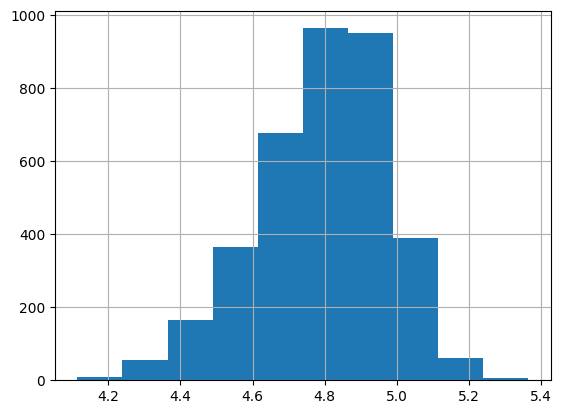

In [112]:
submission['score'].hist(bins=10)

In [113]:
submission.to_csv("submission.csv", index=False)

In [ ]:
from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>